In [1]:
%matplotlib inline


Training a Classifier
=====================

We just saw the theory of simple and more complex  CNN for image classification. Today we start our path into Pytorch for DL and we train our first NN to classify images.

Datasets for computer vision tasks
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

Specifically for vision, the most used package is
``torchvision``. It has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![CIFAR](https://drive.google.com/uc?id=1_xGPuvJSpK631Bs9mS6ktyaSkgzKeig5)


The classes are completely mutually exclusive. There is no overlap between automobiles and trucks.



#Steps to train and test a DL classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
----------------------------------------------------------

Using ``torchvision``, it’s extremely easy to load CIFAR10.




In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
#NORMALIZATION

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#DATA AUGMENTATION
# extra transfrom for the training data, in order to achieve better performance
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 33205741.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


What's in the trainloader?

In [4]:
for i, batch in enumerate(trainloader):
    print(i, type(batch))
    print(i, batch)
    if i>2:
      break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0 <class 'list'>
0 [tensor([[[[ 0.3882, -0.0275, -0.2471,  ..., -0.4588, -0.5059, -0.4980],
          [ 0.5059, -0.1765, -0.2549,  ..., -0.4745, -0.4667, -0.5294],
          [ 0.4667, -0.1686, -0.3255,  ..., -0.4980, -0.4588, -0.5294],
          ...,
          [-0.4588, -0.4667, -0.4275,  ..., -0.4196, -0.4431, -0.4039],
          [-0.5373, -0.4902, -0.4196,  ..., -0.4353, -0.4275, -0.3569],
          [-0.5451, -0.4510, -0.4510,  ..., -0.4118, -0.4118, -0.3882]],

         [[ 0.0118, -0.3333, -0.4902,  ..., -0.6863, -0.7255, -0.7020],
          [ 0.1373, -0.4824, -0.4980,  ..., -0.7020, -0.6863, -0.7333],
          [ 0.0980, -0.4745, -0.5765,  ..., -0.7255, -0.6784, -0.7412],
          ...,
          [-0.6784, -0.6863, -0.6471,  ..., -0.6392, -0.6627, -0.6235],
          [-0.7647, -0.7176, -0.6549,  ..., -0.6549, -0.6471, -0.5765],
          [-0.7961, -0.7020, -0.7020,  ..., -0.6314, -0.6314, -0.6078]],

         [[-0.3647, -0.6471, -0.7176,  ..., -0.7020, -0.7569, -0.8039],
          

Let us show some of the training images, for fun.



 bird  bird  deer horse


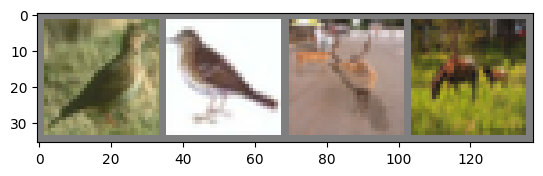

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
----------------------------------------
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()



We can estimate the number of parameters in Net using torch utilities
--------------------------------



In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(net):,} trainable parameters')

The model has 62,006 trainable parameters


3. Define a Loss function and optimizer
---------------------------------------------------------
We need to choose the loss function for our network.
We will use a Classification Cross-Entropy loss since we want to perform a multi-class classification.

For the optimizer we have a long list of options in Pytorch
as we can see in the doc page on the optimizer function:

https://pytorch.org/docs/stable/optim.html

For the moment, we will use the  stochastic gradient descent (SGD) with momentum.
The momentum method (Polyak, 1964), which we refer
to as classical momentum (CM), is a technique for ac-
celerating gradient descent that accumulates a velocity
vector in directions of persistent reduction in the ob-
jective across iterations.

For alternative to classical momentum, takes a look at http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf



In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
---------------------------------------------------------------

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [9]:

def training(model, dataloader, criterion, optimizer, n_epochs=2):
  for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  #BACKWARD PASS (BACKPROPAGATION)
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

  print('Finished Training')

training(net, trainloader, criterion, optimizer, n_epochs=2)

[1,  2000] loss: 2.266
[1,  4000] loss: 1.922
[1,  6000] loss: 1.691
[1,  8000] loss: 1.615
[1, 10000] loss: 1.558
[1, 12000] loss: 1.497
[2,  2000] loss: 1.429
[2,  4000] loss: 1.414
[2,  6000] loss: 1.369
[2,  8000] loss: 1.349
[2, 10000] loss: 1.317
[2, 12000] loss: 1.319
Finished Training


5. Test the network on the test data
-----------------------------------------


We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


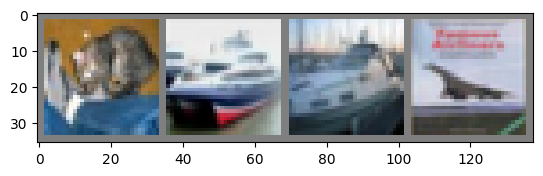

In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)
#images, labels = next(dataiter)
#images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

outputs = net(images.to(torch.device('cuda:0')))

The outputs are energies for the 10 classes.
Higher the energy/probability for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


The results seem pretty good.

Let's estimate the accuracy


In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels=labels.to(device)
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the network on the 10000 test images: 51 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels=labels.to(device)
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 55 %
Accuracy of  bird : 28 %
Accuracy of   cat : 19 %
Accuracy of  deer : 53 %
Accuracy of   dog : 47 %
Accuracy of  frog : 44 %
Accuracy of horse : 66 %
Accuracy of  ship : 68 %
Accuracy of truck : 77 %




How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor on to the GPU, you transfer the neural
net onto the GPU.

But how do we define tensors and move them to GPU in Pytorch?
```python
cuda = torch.device('cuda')     # Default CUDA device
cuda0 = torch.device('cuda:0')
cuda2 = torch.device('cuda:2')  # GPU 2 (these are 0-indexed)

x = torch.tensor([1., 2.], device=cuda0)
# x.device is device(type='cuda', index=0)
y = torch.tensor([1., 2.]).cuda()
# y.device is device(type='cuda', index=0)

with torch.cuda.device(1):
    # allocates a tensor on GPU 1
    a = torch.tensor([1., 2.], device=cuda)

    # transfers a tensor from CPU to GPU 1
    b = torch.tensor([1., 2.]).cuda()
    # a.device and b.device are device(type='cuda', index=1)

    # You can also use ``Tensor.to`` to transfer a tensor:
    b2 = torch.tensor([1., 2.]).to(device=cuda)
```


Now let's set a random seed in order that our obtained results are reproducible



In [ ]:
SEED=1333

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Now we define our device as the first visible cuda device if we have
CUDA available.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


In [ ]:
model_gpu = net.to(device)
criterion_gpu = criterion.to(device)


In [ ]:
model_gpu

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
print(device)

cuda:0


In [ ]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import random

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)


#trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)

#STANDARD PREPROCESSING: STANDARDIZATION/NORMALIZATION
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#DATA AUGMENTATION
# extra transfrom for the training data, in order to achieve better performance
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

validset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

validation_split=0.2
dataset_size = len(trainset) #4996
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

shuffle_dataset=True

random_seed=43
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

BATCH_SIZE=4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          sampler=train_sampler, num_workers=2)

valid_loader=torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, sampler=valid_sampler, num_workers=2)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion= nn.CrossEntropyLoss()
net = net.to(device)
criterion_gpu = criterion.to(device)

def training_GPU(model, dataloader, criterion, optimizer, device, n_epochs=2):
  for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  #BACKWARD PASS (BACKPROPAGATION)
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
  print('Finished Training')



#we can perform at the same time training and validation of the model
def training_validation_GPU(model, trainloader, validloader, criterion, optimizer, avg_losses,avg_vlosses, device, n_epochs=2):
  best_vloss=10000
  for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  #BACKWARD PASS (BACKPROPAGATION)
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, (running_loss /(i+1))))
    avg_loss = running_loss / (i + 1)
    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for j, vdata in enumerate(validloader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device, non_blocking=True)
            vlabels = vlabels.to(device, non_blocking=True)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
        avg_vloss = running_vloss / (j + 1)
    print(type(avg_vloss))
    avg_losses[epoch]=avg_loss
    avg_vlosses[epoch]=avg_vloss
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    #if avg_vloss < best_vloss:
    #    best_vloss = avg_vloss
    #    model_path = 'model_{}_{}'.format(timestamp, epoch)
    #    torch.save(model.state_dict(), 'our_model.pt')

  print('Finished Training')

#estimating the
N_EPOCHS=5
losses=np.zeros(N_EPOCHS)
valid_losses=np.zeros(N_EPOCHS)
training_validation_GPU(net, trainloader, valid_loader, criterion_gpu, optimizer, losses,valid_losses, device , n_epochs=N_EPOCHS)


#training_GPU(net, trainloader, criterion_gpu, optimizer,device , n_epochs=5)

cuda:0
Files already downloaded and verified
Files already downloaded and verified
[1,  2000] training loss: 2.193
[1,  4000] training loss: 2.044
[1,  6000] training loss: 1.947
[1,  8000] training loss: 1.881
[1, 10000] training loss: 1.831
<class 'torch.Tensor'>
LOSS train 1.831157509148121 valid 1.560680627822876
[2,  2000] training loss: 1.582
[2,  4000] training loss: 1.558
[2,  6000] training loss: 1.545
[2,  8000] training loss: 1.534
[2, 10000] training loss: 1.520
<class 'torch.Tensor'>
LOSS train 1.520453314641118 valid 1.391589641571045
[3,  2000] training loss: 1.434
[3,  4000] training loss: 1.416
[3,  6000] training loss: 1.412
[3,  8000] training loss: 1.407
[3, 10000] training loss: 1.398
<class 'torch.Tensor'>
LOSS train 1.3976113354489208 valid 1.252639889717102
[4,  2000] training loss: 1.365
[4,  4000] training loss: 1.352
[4,  6000] training loss: 1.347
[4,  8000] training loss: 1.342
[4, 10000] training loss: 1.337
<class 'torch.Tensor'>
LOSS train 1.336755048930

In [ ]:
print(losses)

[1.83115751 1.52045331 1.39761134 1.33675505 1.28636074]


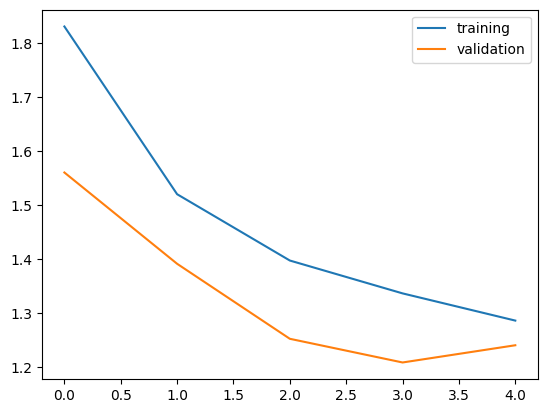

In [ ]:
#PLOT VALIDATION VS TRAINING LOSS
plt.figure(1)
plt.plot(np.arange(N_EPOCHS), losses, label='training')
plt.plot(np.arange(N_EPOCHS), valid_losses, label='validation')
plt.legend(loc='best')
plt.show()

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    all_labels=np.array([])
    predicted_labels=np.array([])
    for data in testloader:
        images, labels = data
        all_labels=np.append(all_labels,labels.numpy())
        labels=labels.to(device)
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels=np.append(predicted_labels,predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('total size', total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

total size 10000
Accuracy of the network on the 10000 test images: 55 %


In [ ]:
len(all_labels)
len(predicted_labels)

10000

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize = (50, 50));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

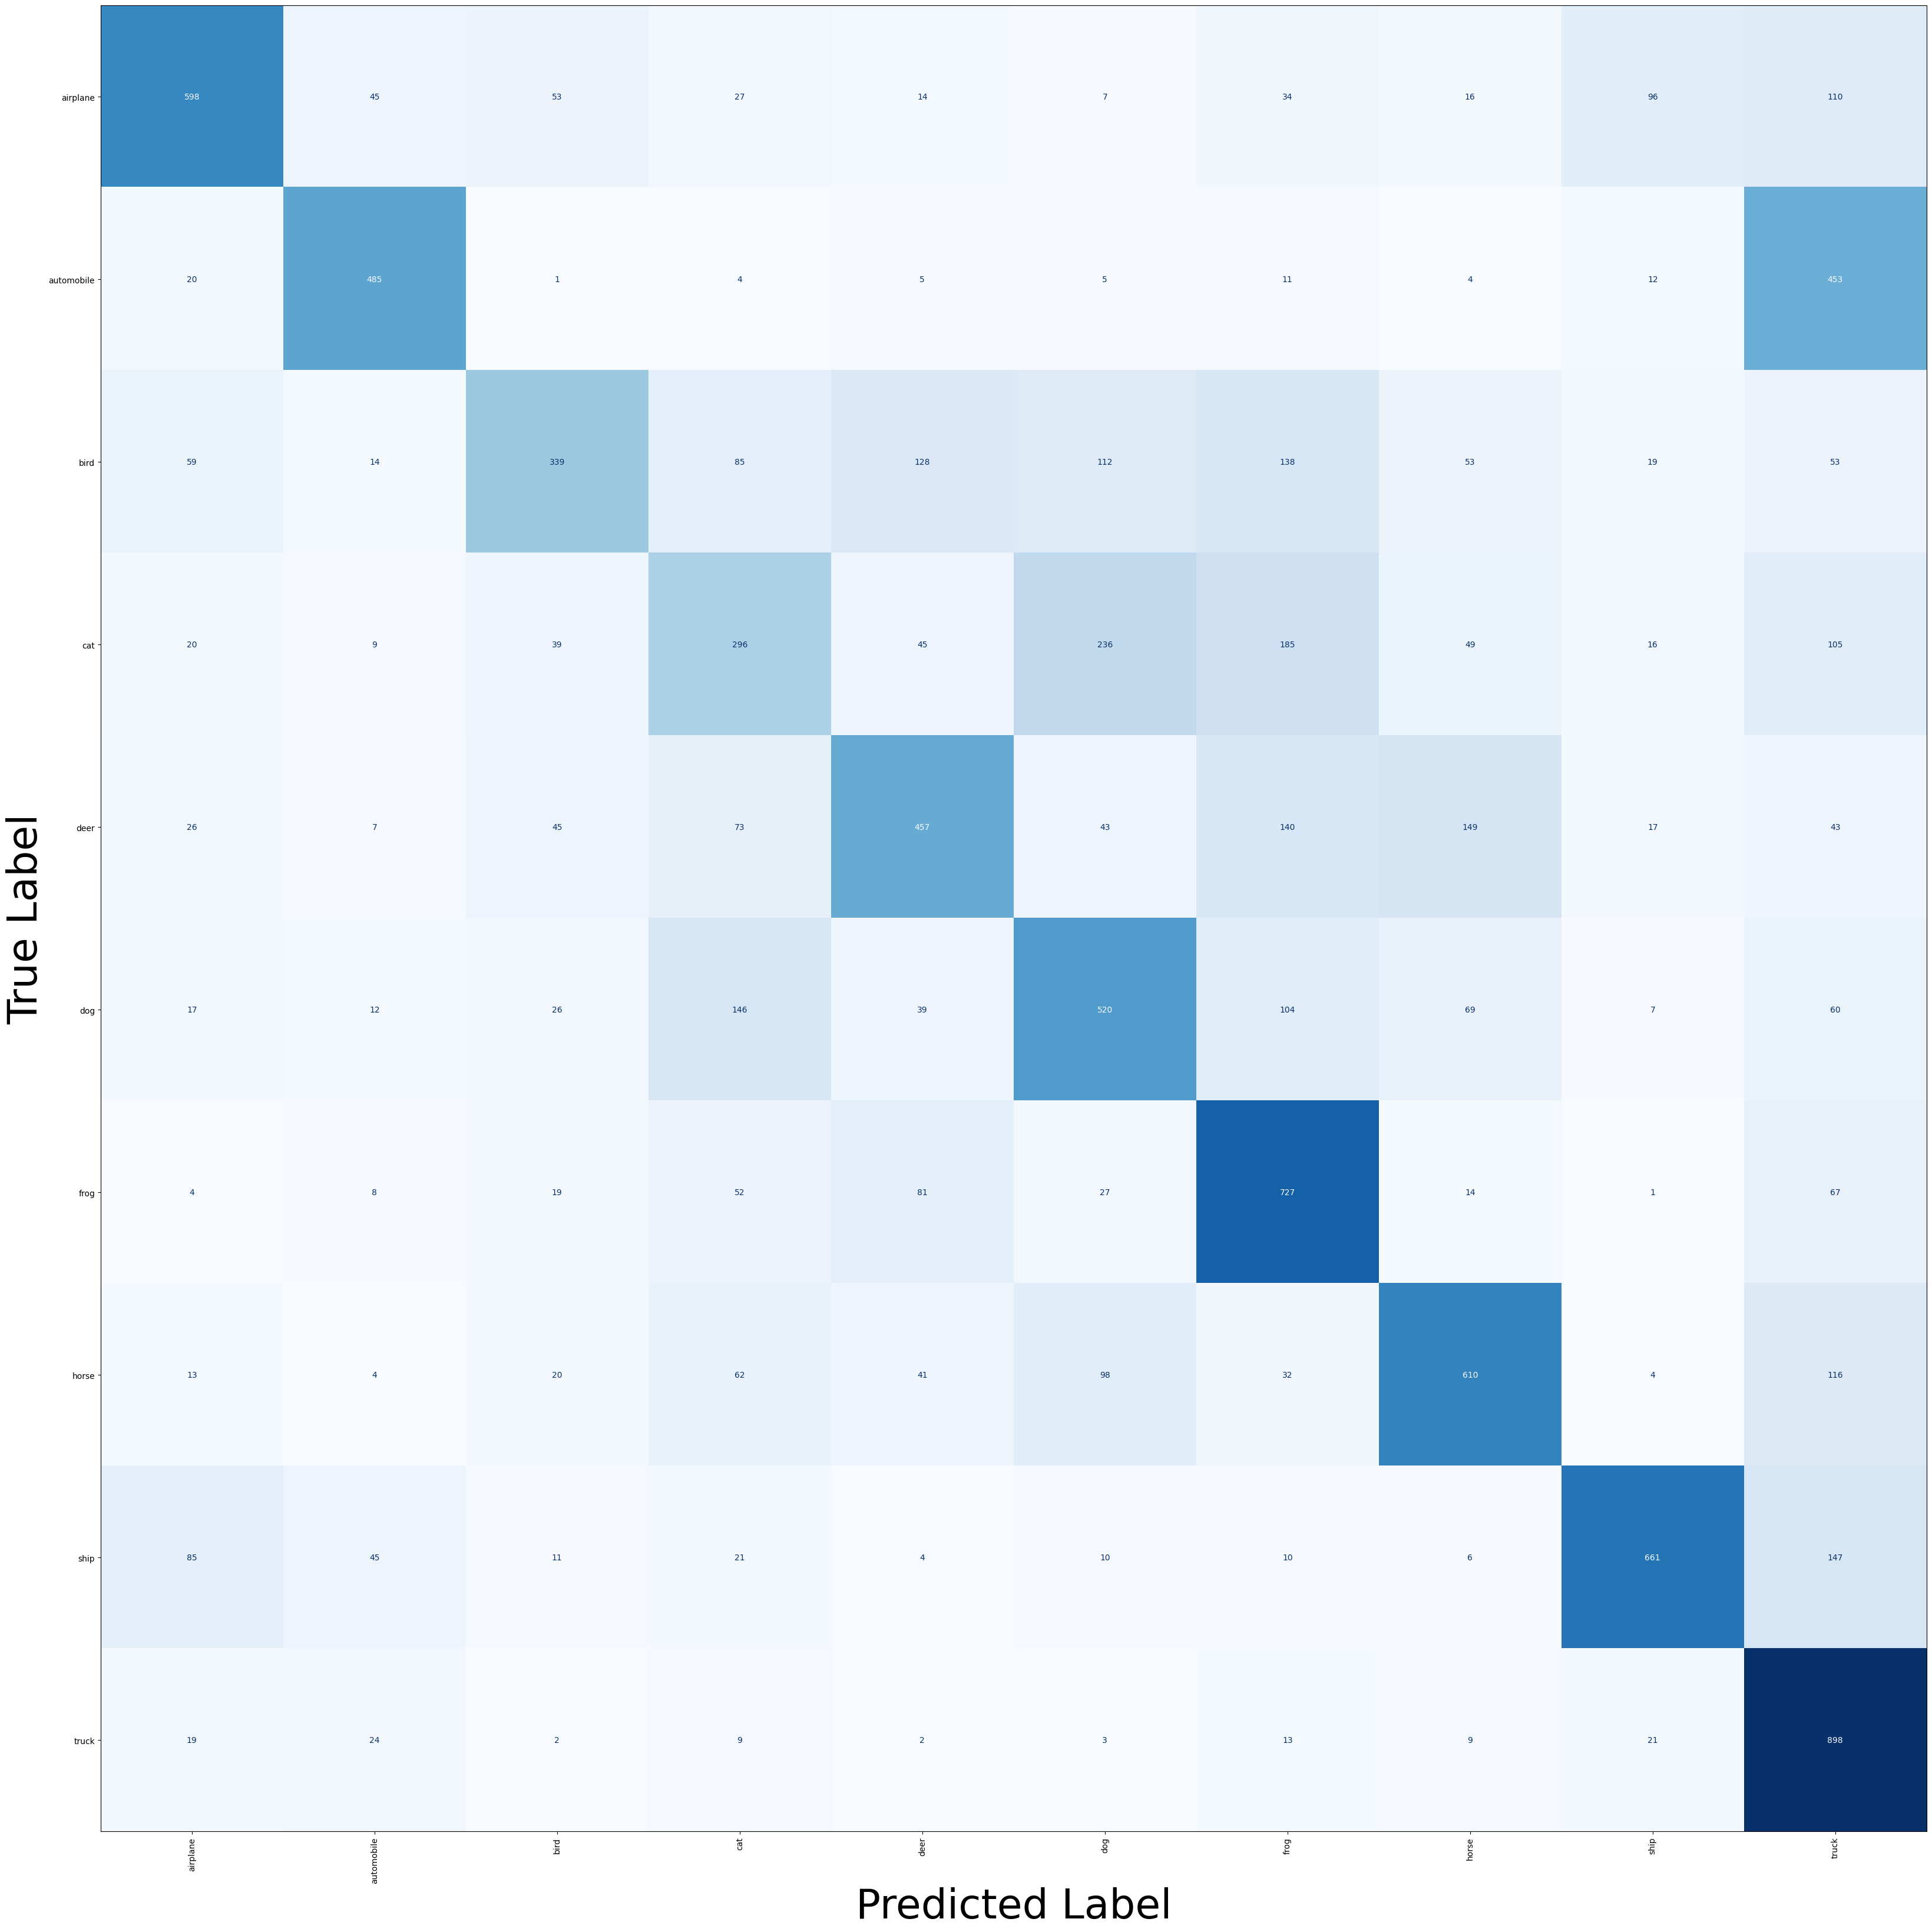

In [ ]:
classes= testset.classes
plot_confusion_matrix(all_labels, predicted_labels, classes)


We do not see a tremendous speedup because our NN is very small!

Loading a saved pretrained model
---------------
If you are doing a longer analyses
it can be good to save the model
at each epoch in which the loss is decreasing, in a Python dictionary,
uncommenting the code snippet at the
end of the training loop function.

In this case you can reload the saved model, as show below:

In [ ]:
PATH=""
torch.save(net.state_dict(), PATH)
saved_model = net
saved_model.load_state_dict(torch.load(PATH))

and you can continue the training.

# ResNet

In the second part of this notebook we'll be implementing one of the [ResNet](https://arxiv.org/abs/1512.03385) (Residual Network) model variants. Much like the [VGG](https://arxiv.org/abs/1409.1556) model introduced in the previous notebook, ResNet was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), which it won in 2015.

ResNet, like VGG, also has multiple *configurations* which specify the number of layers and the sizes of those layers. Each layer is made out of *blocks*, which are made up of convolutional layers, batch normalization layers and *residual connections* (also called *skip connections* or *shortcut connections*).

A residual connection is simply a direct connection between the input of a block and the output of a block. Sometimes the residual connection has layers in it, but most of the time it does not. Below is an example block with an identity residual connection, i.e. no layers in the residual path.

![](https://drive.google.com/uc?id=1NyvyWBdhWbOP1JSN63-gOMGIxjNRBg0r)

The different ResNet configurations are known by the total number of layers within them - ResNet18, ResNet34, ResNet50, ResNet101 and ResNet152.

Below you find a schematic representation of Resnet34

![schema](https://drive.google.com/uc?id=1HRNWyPDWrdRnHgi7n_HPUUB8gRL4Cg-M)


![table](https://drive.google.com/uc?id=1I_o-0H1x5kCgA8oyh7fTa0EDO8IC93F0)


Our `ResNet` class defines the initial 7x7 convolutional layer along with batch normalization, a ReLU activation function and a downsampling max pooling layer. We then build the four layers from the provided configuration, `config`, which specifies: the block to use, the number of blocks in the layer, and the number of channels in that layer. For the `BasicBlock` the number of channels in a layer is simply the number of filters for both of the convolutional layers within the block. For the `Bottleneck` block, the number of channels refers to the number of filters used by the first two convolutional layers - the number of the filters in the final layer is the number of channels multiplied by an `expansion` factor, which is 4 for the `Bottleneck` block (and 1 for the `BasicBlock`). Also note that the `stride` of the first layer is one, whilst the `stride` of the last three layers is two. This `stride` is only used to change the `stride` of the first convolutional layer within a block and also in the "downsampling" residual path - we'll explain what downsampling in ResNets means shortly.

`get_resnet_layer` is used to define the layers from the configuration by creating a `nn.Sequential` from a list of blocks. The first thing it checks is if the first block in a layer needs to have a downsampling residual path - only the first block within a layer ever needs to have a downsampling residual path. So, what is a downsampling residual path?

![](assets/resnet-skip.png)

Remember that the key concept in the ResNet models is the residual (aka skip/identity) connection. However, if the number of channels within the image is changed in the main connection of the block then it won't have the same number of channels as the image from the residual connection and thus we cannot sum them together. Consider the first block in second layer of ResNet18, the image tensor passed to it will have 64 channels and the output will have 128 channels. Thus, we need to make a residual connection between a 64 channel tensor and a 128 channel tensor. ResNet models solve this using a downsampling connection - technically, it doesn't always downsample the image as sometimes the image height and width stay the same - which increases the number of channels in the image through the residual connection by passing them through a convolutional layer.

Thus, to check if we need to downsample within a block or not, we simply check if the number of channels into the block - `in_channels` - is the number of channels out of the block - defined by the `channels` argument multipled by the `expansion` factor of the block. Only the first block in each layer is checked if it needs to downsample or not. After each layer is created, we update `in_channels` to be the number of channels of the image when it is output by the layer.

We then follow the four layers with a 1x1 adaptive average pool. This will take the average over the entire height and width of the image separately for each channel. Thus, if the input to the average pool is `[512, 7, 7]` (512 channels and a height and width of seven) then the output of the average pool will be `[512, 1, 1]`. We then pass this average pooled output to a linear layer to make a prediction. We always know how many channels will be in the image after the fourth layer as we continuously update `in_channels` to be equal to the number of the channels in the image output by each layer.

In [ ]:
import copy
from collections import namedtuple
import os
import random
import shutil
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data


In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]

        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):

        layers = []

        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x, h

One thing to note is that the initial convolutional layer has `bias = False`, which means there is no bias term used by the filters. In fact, every convolutional layer used within every ResNet model always has `bias = False`. The authors of the ResNet paper argue that the bias terms are unnecessary as every convolutional layer in a ResNet is followed by a batch normalization layer which has a $\beta$ (beta) term that does the same thing as the bias term in the convolutional layer, a simple addition. See the previous notebook for more details on how batch normalization works.

The `BasicBlock` is made of two 3x3 convolutional layers. The first, `conv1`, has `stride` which varies depending on the layer (one in the first layer and two in the other layers), whilst the second, `conv2`, always has a `stride` of one. Each of the layers has a `padding` of one - this means before the filters are applied to the input image we add a single pixel, that is zero in every channel, around the entire image. Each convolutional layer is followed by a ReLU activation function and batch normalization.

As mentioned in the previous notebook, it makes more sense to use batch normalization after the activation function, rather than before. However, the original ResNet models used batch normalization before the activation, so we do here as well.

When downsampling, we add a convolutional layer with a 1x1 filter, and no padding, to the residual path. This also has a variable `stride` and is followed by batch normalization. With a stride of one, a 1x1 filter does not change the height and width of an image - it simply has `out_channels` number of filters, each with a depth of `in_channels`, i.e. it is increasing the number of channels in an image via a linear projection and not actually downsampling at all. With a stride of two, it reduces the height and width of the image by two as the 1x1 filter only passes over every other pixel - this time it is actually downsampling the image as well as doing the linear projection of the channels.

The `BasicBlock` has an `expansion` of one as the number of filters used by each of the convolutional layers within a block is the same.

In [ ]:
class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

The bottleneck block
---------------------------------
Instead of two 3x3 convolutional layers it has a 1x1, 3x3 and then another 1x1 convolutional layer. Only the 3x3 convolutional layer has a variable stride and padding, whilst the 1x1 filters have a stride of one and no padding.

The first 1x1 filter, `conv1`, is used to reduce the number of channels in all layers except the first, where it keeps the number of channels the same, e.g. in first block in of second layer it goes from 256 channels to 128. In the case where a 1x1 filter reduces the number of channels it can be thought of as a pooling layer across the channel dimension, but instead of doing a simple maximum or average operation it learns - via its weights - how to most efficiently reduce dimensionality. Reducing the dimensionality is also useful for simply reducing the number of parameters within the model and making it feasible to train.

The second 1x1 filter, `conv3`, is used to increase the number of channels - similar to the convolutional layer in the downsampling path.

The `Bottleneck` block has an `expansion` of four, which means that the number of channels in the image output a block isn't `out_channels`, but `expansion * out_channels`.

The downsampling convolutional layer is similar to that used in the `BasicBlock`, with the `expansion` factor taken into account.


In [ ]:
class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

We prepare the config for a RESNET with 50 layers

We can create the configuration structure of the Resnet architecture using a named tuple:

In [ ]:

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [ ]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

In [ ]:
import torchvision.models as models
pretrained_model = models.resnet50(pretrained = True)



Since the pretained model downloaded from torchvision had more dimensions in the last layer we need to add a layer to our network

In [ ]:
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [ ]:
pretrained_model.fc = fc
model = ResNet(resnet50_config, OUTPUT_DIM)

model.load_state_dict(pretrained_model.state_dict())

CIFAR specific RESNET version

In [ ]:


class Identity(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f

    def forward(self, x):
        return self.f(x)


class CIFARBasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            identity_fn = lambda x : F.pad(x[:, :, ::2, ::2],
                                           [0, 0, 0, 0, in_channels // 2, in_channels // 2])
            downsample = Identity(identity_fn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x




In [ ]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100,
                   smooth_f = 0.05, diverge_th = 5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()

            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)



In [ ]:
class CIFARResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()

        block, layers, channels = config
        self.in_channels = channels[0]

        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)

        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, layers[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, layers[2], channels[2], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):

        layers = []

        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(channels, channels))

        self.in_channels = channels

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x, h

he `CIFARBasicBlock` is similar to the standard `BasicBlock`, the only difference is in the downsampling residual connection.

The [paper](https://arxiv.org/abs/1512.03385) states that the ResNet models for CIFAR use a downsampling connection that uses "zero padding" and "all shortcuts are parameter free". We achieve this by using an `Identity` module, which is initialized with a function and applies that function when called.

In [ ]:
cifar_resnet20_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [3, 3, 3],
                                     channels = [16, 32, 64])

cifar_resnet32_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [5, 5, 5],
                                     channels = [16, 32, 64])

In [ ]:
print(cifar_resnet32_config)

ResNetConfig(block=<class '__main__.CIFARBasicBlock'>, n_blocks=[5, 5, 5], channels=[16, 32, 64])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

#STANDARD PREPROCESSING: STANDARDIZATION/NORMALIZATION
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#DATA AUGMENTATION
# extra transfrom for the training data, in order to achieve better performance
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

validset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

validation_split=0.2
dataset_size = len(trainset) #4996
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

shuffle_dataset=True

random_seed=43
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

BATCH_SIZE=4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          sampler=train_sampler, num_workers=2)

valid_loader=torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, sampler=valid_sampler, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)
